<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/Barrages/TurbineGeneratorMaps/TurbineHill_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copy libs from GitHub

In [13]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py
if not pathlib.Path("label_lines_core.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/label_lines_core.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5315  100  5315    0     0  54793      0 --:--:-- --:--:-- --:--:-- 55364


In [17]:
from dataclasses import dataclass
import matplotlib.pyplot as mpl
import pandas as pd
import numpy as np
from scipy import interpolate

from label_lines_core import labelLine, labelLines
import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']

Excel file with turbine hill chart data

In [3]:
hill_data = 'https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/TurbineGeneratorMaps/TurbineHill_Data.xlsx'

In [5]:
rpm2rads = np.pi / 30.0
gr = 9.8
sqrt_gr = np.sqrt( gr )

In [6]:
def LSQ_polyfit( NP, XL, XC_fun, XC_der ):
  
    ########################################################
    # LINEAR LEAST SQUARES PROBLEM
    #
    ( xl, yl ) = XL

    # Vandermonde matrix
    X = xl[:, None] ** np.arange( NP, -1, -1 )

    XTX = X.transpose().dot( X )
    XTy = X.transpose().dot( yl )

    # NO CONSTRAINTS IMPOSED => standard LSQ solution
    if XC_fun == None and XC_der == None:
      AA = XTX
      bb = XTy
      return np.linalg.solve( AA, bb )

    ########################################################
    # LAGRANGE MULTIPLIERS FOR CONSTRAINTS
    #
    if XC_fun != None:
      ( xc_fun, yc_fun ) = XC_fun 

      # function constraints
      xF = np.array( xc_fun ) 
      bF = np.array( yc_fun ) 

      # Vandermonde matrix
      AF = xF[:, None] ** np.arange( NP, -1, -1 )

    if XC_der != None:
      ( xc_der, yc_der ) = XC_der

      # derivative constraints
      xD = np.array( xc_der )
      bD = np.array( yc_der ) 

      # Derivative of the Vandermonde matrix
      AD = np.array( [  (i*xD**(i-1) if i > 0 else 0*xD) \
                        for i in range(NP,-1,-1) ] ).T

    if XC_fun != None and XC_der != None:
      Ac = np.block( [ [AF], [AD] ] )
      bc = np.block( [ bF, bD ] )
    elif XC_fun != None:
      Ac = AF
      bc = bF
    elif XC_der != None:
      Ac = AD
      bc = bD
      
    AcT = Ac.transpose()
    Z0 = np.zeros( ( Ac.shape[0], Ac.shape[0] ) )

    ########################################################
    # ASSEMBLE AND SOLVE GLOBAL SYSTEM
    #
    AA = np.block( [ [ XTX, AcT ], [ Ac, Z0 ] ] )
    bb = np.block( [ XTy, bc ] )
      
    alambda = np.linalg.solve( AA, bb )

    # final polynomial coeffs without lambdas
    return alambda[ 0:NP+1 ]

In [7]:
def param_spline( x, y, n, pwr ):
    m = x.size
    l = np.zeros( m )
    for i in range( 1, m ):
        dl = ( (x[i]-x[i-1])**2 + (y[i]-y[i-1])**2 )**pwr
        l[i] = l[i-1] + dl
    
    l /= l[-1]
    
    xtck = interpolate.CubicSpline( l , x )
    ytck = interpolate.CubicSpline( l , y )
    xtck_der = xtck.derivative()
    
    unew = np.linspace(0,1, n )

    xnew = xtck( unew ) 
    ynew = ytck( unew ) 
    
    return xnew, ynew, unew, xtck, ytck

In [10]:
dfe = pd.read_excel( hill_data, 'efficiency' )
res = [key[4:] for key in dfe.keys() if 'n11_' in key] 

## Plot isolines

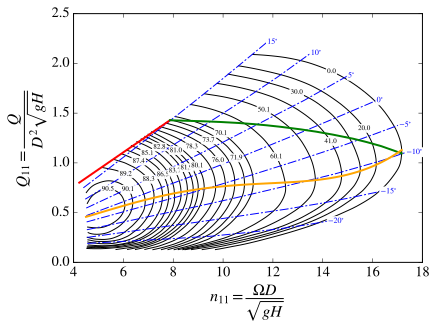

In [19]:
bep_lst_x = []
bep_lst_y = []
bep_lst_v = []

mpl.subplots_adjust( top=0.95, bottom=0.18, left=0.14, right=0.95 )
data_dic = {}

n_spline = 100
sg = np.sqrt( 9.8 )
xvals = []
i = 1

for key in res:
  if key != '100':

    x = dfe[ 'n11_' + key ]
    y = dfe[ 'Q11_' + key ]

    x = np.array( x[~np.isnan(x)] )
    y = np.array( y[~np.isnan(y)] )
    
    x *= ( rpm2rads / sg )
    y /= sg
    
    assert( x.size == y.size )

    x1, y1, u1, x_spline, y_spline = param_spline( x, y, n_spline, 0.025 )

    xder = x_spline.derivative()
    umax = np.array( xder.roots() )
    u0 = umax[ (umax>0.0) & (umax<1.0) ]
    x0 = x_spline( u0 )[0]
    y0 = y_spline( u0 )[0]
    #plt.plot( x0, y0, 'ro', label='' ) 
    bep_lst_x.append( x0 )
    bep_lst_y.append( y0 )
    mpl.plot( x1, y1, 'k-', lw=1, label= ( '%.1f' % (float(key)*0.91) ) ) 
    xvals.append( np.max(x1)*.97 if i%2==0 else np.mean(x1) )
    i+=1
    
    data_dic[ key ] = [ x1, y1, x_spline, y_spline, float( key ) ]
    
mpl.xlabel(r'$n_{11}=\dfrac{\Omega D}{\sqrt{gH}}$')
mpl.ylabel(r'$Q_{11}=\dfrac{Q}{D^2\sqrt{gH}}$');
labelLines( mpl.gca().get_lines(), color='b', align = False, xvals = xvals )


dfa = pd.read_excel( hill_data, 'angles' )
dfa.keys()

resa = [key[4:] for key in dfa.keys() if 'n11_' in key] 
avals = []

for key in resa:
  if key != '100':

    x = dfa[ 'n11_' + key ]
    y = dfa[ 'Q11_' + key ]

    x = np.array( x[~np.isnan(x)] )
    y = np.array( y[~np.isnan(y)] )
    
    x *= ( rpm2rads / sg )
    y /= sg
    
    assert( x.size == y.size )
    
    plt.plot( x, y, 'b-', label=key, lw=1, dashes=(9,2,2,2) )

    lbl = '$%s\!^\circ$' % key[4:] 
    mpl.gca().text(  x[-1], y[-1], lbl, horizontalalignment='left',
              verticalalignment='center', fontsize=8, color='b',
              bbox=dict( boxstyle='round, pad=0.1', edgecolor='w', facecolor='w', 
                          alpha=0.99) )
    
dfm = pd.read_excel( hill_data, 'max_output' )
dfm.keys()

n1_out_max = np.array( dfm[ 'n11_left_B' ] )
Q1_out_max = np.array( dfm[ 'Q11_left_B' ] )
n1_out_max = np.array( n1_out_max[~np.isnan(n1_out_max)] ) * ( rpm2rads / sg )
Q1_out_max = np.array( Q1_out_max[~np.isnan(Q1_out_max)] ) / sg
mpl.plot( n1_out_max, Q1_out_max, 'r-', lw=2 );

n2_out_max = np.array( dfm[ 'n11_max_out' ] )
Q2_out_max = np.array( dfm[ 'Q11_max_out' ] )
n2_out_max = np.array( n2_out_max[~np.isnan(n2_out_max)] ) * ( rpm2rads / sg )
Q2_out_max = np.array( Q2_out_max[~np.isnan(Q2_out_max)] ) / sg
mpl.plot( n2_out_max, Q2_out_max, 'g-', lw=2 );

bep_lst_x = np.array( bep_lst_x )
bep_lst_y = np.array( bep_lst_y )
bep_lst_x = np.insert( bep_lst_x, 0, 5.4291 )
bep_lst_y = np.insert( bep_lst_y, 0, 0.5271 )

bep_array = LSQ_polyfit( 4, [bep_lst_x, bep_lst_y], [ [bep_lst_x[0],bep_lst_x[19]], [bep_lst_y[0],bep_lst_y[19]] ], None )

bep = np.poly1d( bep_array )
bep_rng_x = np.linspace( 4.5, np.max( bep_lst_x ), 100 )
bep_rng_y = bep( bep_rng_x )
#plt.plot( bep_lst_x, bep_lst_y, 'ko' )
mpl.plot( bep_rng_x, bep_rng_y, '-', lw=2, color='orange' )

mpl.savefig('TurbineHill_Plot.pdf')
mpl.savefig('TurbineHill_Plot.svg')